In [9]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_43656\2827459508.py:399: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-04 21:58:49,530] A new study created in memory with name: no-name-7797383b-3191-4270-b18c-3e873f8dc526
[I 2025-06-04 22:01:15,847] Trial 0 finished with value: 0.9862718939781189 and parameters: {'lr': 0.013628089433912041, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4764506660253228}. Best is trial 0 with value: 0.9862718939781189.


Cross Validation Accuracies:
[0.851511538028717, 1.310288667678833, 0.7086206078529358, 0.9800243973731995, 1.0809142589569092]
Mean Cross Validation Accuracy:
0.9862718939781189
Standard Deviation of Cross Validation Accuracy:
0.2045647419887428


[I 2025-06-04 22:03:30,375] Trial 1 finished with value: 2.0782729387283325 and parameters: {'lr': 0.558971673371473, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.457999539795082}. Best is trial 0 with value: 0.9862718939781189.


Cross Validation Accuracies:
[1.9701011180877686, 1.8097718954086304, 2.781630516052246, 1.951502799987793, 1.8783583641052246]
Mean Cross Validation Accuracy:
2.0782729387283325
Standard Deviation of Cross Validation Accuracy:
0.3562421479405439


[I 2025-06-04 22:05:12,153] Trial 2 finished with value: 0.42090708315372466 and parameters: {'lr': 0.04768715183705333, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42182460477053807}. Best is trial 2 with value: 0.42090708315372466.


Cross Validation Accuracies:
[0.09682844579219818, 0.16749422252178192, 1.7470059394836426, 0.038322560489177704, 0.05488424748182297]
Mean Cross Validation Accuracy:
0.42090708315372466
Standard Deviation of Cross Validation Accuracy:
0.6645489976071055


[I 2025-06-04 22:07:02,662] Trial 3 finished with value: 0.18408576622605324 and parameters: {'lr': 0.380796585370837, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2080612551935416}. Best is trial 3 with value: 0.18408576622605324.


Cross Validation Accuracies:
[0.07924030721187592, 0.11506973206996918, 0.279947429895401, 0.03825082257390022, 0.4079205393791199]
Mean Cross Validation Accuracy:
0.18408576622605324
Standard Deviation of Cross Validation Accuracy:
0.1387912664907226


[I 2025-06-04 22:08:56,547] Trial 4 finished with value: 2.5688523769378664 and parameters: {'lr': 0.14629622404671092, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.48576631784460844}. Best is trial 3 with value: 0.18408576622605324.


Cross Validation Accuracies:
[2.7313380241394043, 2.3702750205993652, 2.2903037071228027, 2.3492932319641113, 3.1030519008636475]
Mean Cross Validation Accuracy:
2.5688523769378664
Standard Deviation of Cross Validation Accuracy:
0.3088686656029613


[I 2025-06-04 22:10:49,163] Trial 5 finished with value: 0.21311199069023132 and parameters: {'lr': 0.061328800759165185, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4786683982662364}. Best is trial 3 with value: 0.18408576622605324.


Cross Validation Accuracies:
[0.2496664971113205, 0.08359824120998383, 0.2070590853691101, 0.2759338319301605, 0.24930229783058167]
Mean Cross Validation Accuracy:
0.21311199069023132
Standard Deviation of Cross Validation Accuracy:
0.06841491500343472


[I 2025-06-04 22:12:35,334] Trial 6 finished with value: 1.5740769624710083 and parameters: {'lr': 0.0206001871209718, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4866456321869238}. Best is trial 3 with value: 0.18408576622605324.


Cross Validation Accuracies:
[1.8755625486373901, 2.021716833114624, 0.8298025131225586, 1.3837018013000488, 1.75960111618042]
Mean Cross Validation Accuracy:
1.5740769624710083
Standard Deviation of Cross Validation Accuracy:
0.4279909770098711


[I 2025-06-04 22:14:09,358] Trial 7 finished with value: 0.06535318940877914 and parameters: {'lr': 0.0012869085836649064, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.33279219512015246}. Best is trial 7 with value: 0.06535318940877914.


Cross Validation Accuracies:
[0.07434409856796265, 0.1250099539756775, 0.02732173353433609, 0.04107094183564186, 0.059019219130277634]
Mean Cross Validation Accuracy:
0.06535318940877914
Standard Deviation of Cross Validation Accuracy:
0.03381095789450754


[I 2025-06-04 22:15:53,130] Trial 8 finished with value: 8.991127204895019 and parameters: {'lr': 0.6079973034803693, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2826704206365178}. Best is trial 7 with value: 0.06535318940877914.


Cross Validation Accuracies:
[3.1258835792541504, 11.881115913391113, 13.782845497131348, 3.2895474433898926, 12.876243591308594]
Mean Cross Validation Accuracy:
8.991127204895019
Standard Deviation of Cross Validation Accuracy:
4.760584477315619


[I 2025-06-04 22:17:28,366] Trial 9 finished with value: 0.07652701139450073 and parameters: {'lr': 0.002786158074105552, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.36422518294759676}. Best is trial 7 with value: 0.06535318940877914.


Cross Validation Accuracies:
[0.0713350921869278, 0.16014988720417023, 0.04991289600729942, 0.03924784064292908, 0.06198934093117714]
Mean Cross Validation Accuracy:
0.07652701139450073
Standard Deviation of Cross Validation Accuracy:
0.043195214910926566


[I 2025-06-04 22:19:45,914] Trial 10 finished with value: 0.06201532334089279 and parameters: {'lr': 0.0010160448177472534, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12876636145930787}. Best is trial 10 with value: 0.06201532334089279.


Cross Validation Accuracies:
[0.08852856606245041, 0.10689140856266022, 0.017897307872772217, 0.03859461098909378, 0.058164723217487335]
Mean Cross Validation Accuracy:
0.06201532334089279
Standard Deviation of Cross Validation Accuracy:
0.03233131992871609


[I 2025-06-04 22:21:50,995] Trial 11 finished with value: 0.054170867800712584 and parameters: {'lr': 0.001355551873421261, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1299219055451044}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.05411376804113388, 0.10145337879657745, 0.01878836750984192, 0.04001409187912941, 0.056484732776880264]
Mean Cross Validation Accuracy:
0.054170867800712584
Standard Deviation of Cross Validation Accuracy:
0.027178405799133772


[I 2025-06-04 22:23:59,120] Trial 12 finished with value: 0.07054541036486625 and parameters: {'lr': 0.003631045645829397, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1302072692776109}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09612943977117538, 0.1113273873925209, 0.037303294986486435, 0.05452704429626465, 0.05343988537788391]
Mean Cross Validation Accuracy:
0.07054541036486625
Standard Deviation of Cross Validation Accuracy:
0.028184880636130297


[I 2025-06-04 22:26:05,955] Trial 13 finished with value: 0.06051496639847755 and parameters: {'lr': 0.0011975163667364856, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10436244922010471}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07024240493774414, 0.1153348907828331, 0.018520623445510864, 0.03870489448308945, 0.05977201834321022]
Mean Cross Validation Accuracy:
0.06051496639847755
Standard Deviation of Cross Validation Accuracy:
0.03267905512361175


[I 2025-06-04 22:28:20,913] Trial 14 finished with value: 0.07530784532427788 and parameters: {'lr': 0.005483435525273067, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.19635742528272535}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08464239537715912, 0.11182783544063568, 0.03117464855313301, 0.0777573361992836, 0.07113701105117798]
Mean Cross Validation Accuracy:
0.07530784532427788
Standard Deviation of Cross Validation Accuracy:
0.026046030116352127


[I 2025-06-04 22:30:30,470] Trial 15 finished with value: 0.05626193918287754 and parameters: {'lr': 0.008569678574037145, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18908847579364693}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07891388982534409, 0.0782851129770279, 0.021993311122059822, 0.042441144585609436, 0.059676237404346466]
Mean Cross Validation Accuracy:
0.05626193918287754
Standard Deviation of Cross Validation Accuracy:
0.021795144948780477


[I 2025-06-04 22:32:51,655] Trial 16 finished with value: 0.06911282725632191 and parameters: {'lr': 0.008899995494653935, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1912279708727234}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07759527117013931, 0.12270358204841614, 0.028626931831240654, 0.054697662591934204, 0.06194068863987923]
Mean Cross Validation Accuracy:
0.06911282725632191
Standard Deviation of Cross Validation Accuracy:
0.031119977914333175


[I 2025-06-04 22:35:03,308] Trial 17 finished with value: 0.0808277677744627 and parameters: {'lr': 0.006271287796693338, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.252911651223029}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09892146289348602, 0.12766017019748688, 0.025953954085707664, 0.0689113438129425, 0.08269190788269043]
Mean Cross Validation Accuracy:
0.0808277677744627
Standard Deviation of Cross Validation Accuracy:
0.033696490401506934


[I 2025-06-04 22:37:22,628] Trial 18 finished with value: 0.06643232144415379 and parameters: {'lr': 0.0024363250145615664, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1544235376784547}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08293116092681885, 0.12288036942481995, 0.029039720073342323, 0.03834889829158783, 0.05896145850419998]
Mean Cross Validation Accuracy:
0.06643232144415379
Standard Deviation of Cross Validation Accuracy:
0.03376771508826856


[I 2025-06-04 22:39:22,430] Trial 19 finished with value: 0.07384588941931725 and parameters: {'lr': 0.025546533278208754, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2524429455412377}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09055491536855698, 0.10275264829397202, 0.0837058424949646, 0.03852364420890808, 0.053692396730184555]
Mean Cross Validation Accuracy:
0.07384588941931725
Standard Deviation of Cross Validation Accuracy:
0.023940907274950816


[I 2025-06-04 22:41:31,828] Trial 20 finished with value: 1.085438923537731 and parameters: {'lr': 0.11100536116138897, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16621747794982616}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[1.0463809967041016, 1.6343191862106323, 1.949804425239563, 0.7327932119369507, 0.0638967975974083]
Mean Cross Validation Accuracy:
1.085438923537731
Standard Deviation of Cross Validation Accuracy:
0.6660075221667949


[I 2025-06-04 22:43:49,509] Trial 21 finished with value: 0.06422765031456948 and parameters: {'lr': 0.0017380220195673307, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10098661024880135}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07602042704820633, 0.13221144676208496, 0.01780156046152115, 0.04211801663041115, 0.05298680067062378]
Mean Cross Validation Accuracy:
0.06422765031456948
Standard Deviation of Cross Validation Accuracy:
0.03881092780111139


[I 2025-06-04 22:45:23,450] Trial 22 finished with value: 0.08250521197915077 and parameters: {'lr': 0.004018248207487371, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10719478772772292}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.10290881991386414, 0.13947616517543793, 0.0347508080303669, 0.04437616467475891, 0.09101410210132599]
Mean Cross Validation Accuracy:
0.08250521197915077
Standard Deviation of Cross Validation Accuracy:
0.03864894637840072


[I 2025-06-04 22:46:58,692] Trial 23 finished with value: 0.11454627886414528 and parameters: {'lr': 0.01053903175990653, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.22716563068325496}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08871008455753326, 0.234655499458313, 0.050980497151613235, 0.10039922595024109, 0.09798608720302582]
Mean Cross Validation Accuracy:
0.11454627886414528
Standard Deviation of Cross Validation Accuracy:
0.0626238316724784


[I 2025-06-04 22:48:32,885] Trial 24 finished with value: 0.059228019788861275 and parameters: {'lr': 0.001975198280176435, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.15597006718598547}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07045098394155502, 0.1096777468919754, 0.018848272040486336, 0.042811691761016846, 0.054351404309272766]
Mean Cross Validation Accuracy:
0.059228019788861275
Standard Deviation of Cross Validation Accuracy:
0.03031478557346986


[I 2025-06-04 22:50:08,042] Trial 25 finished with value: 0.06470221541821956 and parameters: {'lr': 0.002507880138750425, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16789384104419475}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.0774293914437294, 0.12708641588687897, 0.020661672577261925, 0.03996121510863304, 0.0583723820745945]
Mean Cross Validation Accuracy:
0.06470221541821956
Standard Deviation of Cross Validation Accuracy:
0.03645688625733539


[I 2025-06-04 22:51:44,228] Trial 26 finished with value: 0.07789086177945137 and parameters: {'lr': 0.006355082219426452, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13700453790250494}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09969887137413025, 0.15291863679885864, 0.018361475318670273, 0.03823825716972351, 0.08023706823587418]
Mean Cross Validation Accuracy:
0.07789086177945137
Standard Deviation of Cross Validation Accuracy:
0.04738425455003592


[I 2025-06-04 22:53:23,745] Trial 27 finished with value: 0.05580149367451668 and parameters: {'lr': 0.0020649733175508154, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.22991008163444837}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.04163900017738342, 0.10014063119888306, 0.023446273058652878, 0.043325573205947876, 0.07045599073171616]
Mean Cross Validation Accuracy:
0.05580149367451668
Standard Deviation of Cross Validation Accuracy:
0.026772368274397232


[I 2025-06-04 22:55:02,455] Trial 28 finished with value: 0.32513105869293213 and parameters: {'lr': 0.01807118151492321, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24071493588915774}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.38533830642700195, 0.2462073266506195, 0.34952396154403687, 0.3167981207370758, 0.3277875781059265]
Mean Cross Validation Accuracy:
0.32513105869293213
Standard Deviation of Cross Validation Accuracy:
0.04588110028992247


[I 2025-06-04 22:57:10,901] Trial 29 finished with value: 0.17173040583729743 and parameters: {'lr': 0.01127063518346328, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.28733369766161243}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.11448044329881668, 0.4928029775619507, 0.08754929900169373, 0.040078189224004745, 0.12374112010002136]
Mean Cross Validation Accuracy:
0.17173040583729743
Standard Deviation of Cross Validation Accuracy:
0.1631483318685022


[I 2025-06-04 22:58:27,802] Trial 30 finished with value: 0.30632067918777467 and parameters: {'lr': 0.004441214664579173, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21466243923532313}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.3527398705482483, 0.3652059733867645, 0.268563449382782, 0.2788812220096588, 0.2662128806114197]
Mean Cross Validation Accuracy:
0.30632067918777467
Standard Deviation of Cross Validation Accuracy:
0.043380610689292984


[I 2025-06-04 23:00:05,451] Trial 31 finished with value: 0.06656940840184689 and parameters: {'lr': 0.0018000558744251836, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18096931227731347}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07649169862270355, 0.11052870005369186, 0.02573704905807972, 0.060836248099803925, 0.05925334617495537]
Mean Cross Validation Accuracy:
0.06656940840184689
Standard Deviation of Cross Validation Accuracy:
0.027511985129736006


[I 2025-06-04 23:01:49,645] Trial 32 finished with value: 0.06159418486058712 and parameters: {'lr': 0.0019101567595495332, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1500109248828576}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.0888759046792984, 0.10860070586204529, 0.017792655155062675, 0.038692474365234375, 0.05400918424129486]
Mean Cross Validation Accuracy:
0.06159418486058712
Standard Deviation of Cross Validation Accuracy:
0.033028774834918555


[I 2025-06-04 23:03:30,030] Trial 33 finished with value: 0.0657969679683447 and parameters: {'lr': 0.001514785947355786, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1810809854779439}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09582830220460892, 0.11364667117595673, 0.0183554757386446, 0.03919555991888046, 0.061958830803632736]
Mean Cross Validation Accuracy:
0.0657969679683447
Standard Deviation of Cross Validation Accuracy:
0.035112779796412336


[I 2025-06-04 23:05:30,472] Trial 34 finished with value: 0.06349673755466938 and parameters: {'lr': 0.0030346858503419415, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2671254560074183}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.15197749435901642, 0.05144086852669716, 0.018784182146191597, 0.04089304804801941, 0.05438809469342232]
Mean Cross Validation Accuracy:
0.06349673755466938
Standard Deviation of Cross Validation Accuracy:
0.04597237228582533


[I 2025-06-04 23:06:49,035] Trial 35 finished with value: 0.26263178288936617 and parameters: {'lr': 0.00780612471893273, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31957297536743745}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.18078172206878662, 0.3615826666355133, 0.24998803436756134, 0.2516539692878723, 0.26915252208709717]
Mean Cross Validation Accuracy:
0.26263178288936617
Standard Deviation of Cross Validation Accuracy:
0.05798897594942112


[I 2025-06-04 23:07:51,474] Trial 36 finished with value: 0.088022555783391 and parameters: {'lr': 0.04590940167209346, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21581260753475817}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.13540074229240417, 0.1590692698955536, 0.018793968483805656, 0.07043170183897018, 0.05641709640622139]
Mean Cross Validation Accuracy:
0.088022555783391
Standard Deviation of Cross Validation Accuracy:
0.05175571204698159


[I 2025-06-04 23:10:05,236] Trial 37 finished with value: 0.9388755083084106 and parameters: {'lr': 0.015343047130537317, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2004875576273262}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[1.0553747415542603, 0.5729987025260925, 1.1272835731506348, 1.2128634452819824, 0.7258570790290833]
Mean Cross Validation Accuracy:
0.9388755083084106
Standard Deviation of Cross Validation Accuracy:
0.2463256982426318


[I 2025-06-04 23:11:24,969] Trial 38 finished with value: 13.729644298553467 and parameters: {'lr': 0.9105564693177566, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12328264935932301}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[8.953154563903809, 17.97122573852539, 4.255947589874268, 22.852882385253906, 14.615011215209961]
Mean Cross Validation Accuracy:
13.729644298553467
Standard Deviation of Cross Validation Accuracy:
6.550941068104617


[I 2025-06-04 23:12:58,468] Trial 39 finished with value: 0.06196592673659325 and parameters: {'lr': 0.001009724483316251, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4532893024978725}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08058243989944458, 0.11860378086566925, 0.01795513555407524, 0.03828473761677742, 0.05440353974699974]
Mean Cross Validation Accuracy:
0.06196592673659325
Standard Deviation of Cross Validation Accuracy:
0.034955283544291754


[I 2025-06-04 23:14:06,217] Trial 40 finished with value: 0.16556514650583268 and parameters: {'lr': 0.0021883785129286075, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3847873922556616}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06881105154752731, 0.1265510469675064, 0.3009771406650543, 0.1200924813747406, 0.21139401197433472]
Mean Cross Validation Accuracy:
0.16556514650583268
Standard Deviation of Cross Validation Accuracy:
0.0817164747164472


[I 2025-06-04 23:15:35,692] Trial 41 finished with value: 0.0644171267747879 and parameters: {'lr': 0.0012405191660243178, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.15324131425522755}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06722215563058853, 0.14116814732551575, 0.02081235498189926, 0.03861246630549431, 0.054270509630441666]
Mean Cross Validation Accuracy:
0.0644171267747879
Standard Deviation of Cross Validation Accuracy:
0.04139757917313398


[I 2025-06-04 23:17:05,689] Trial 42 finished with value: 0.06446057297289372 and parameters: {'lr': 0.0013587902031823793, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11261181883781529}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08483193814754486, 0.11685817688703537, 0.021083379164338112, 0.0398908406496048, 0.059638530015945435]
Mean Cross Validation Accuracy:
0.06446057297289372
Standard Deviation of Cross Validation Accuracy:
0.03367196520087291


[I 2025-06-04 23:18:34,743] Trial 43 finished with value: 0.06869797930121421 and parameters: {'lr': 0.003500635403386286, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.142533130192305}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08919795602560043, 0.1370379775762558, 0.019248414784669876, 0.03837267681956291, 0.05963287129998207]
Mean Cross Validation Accuracy:
0.06869797930121421
Standard Deviation of Cross Validation Accuracy:
0.041322303891449697


[I 2025-06-04 23:19:43,649] Trial 44 finished with value: 0.07778725624084473 and parameters: {'lr': 0.00471998005430938, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.17087075653421596}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.11831483244895935, 0.14139163494110107, 0.01788567751646042, 0.04962954297661781, 0.061714593321084976]
Mean Cross Validation Accuracy:
0.07778725624084473
Standard Deviation of Cross Validation Accuracy:
0.045447525491332116


[I 2025-06-04 23:21:38,137] Trial 45 finished with value: 0.08730480447411537 and parameters: {'lr': 0.2552064928922028, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1186804419648492}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.04496544972062111, 0.03896845877170563, 0.1188424676656723, 0.12181691825389862, 0.1119307279586792]
Mean Cross Validation Accuracy:
0.08730480447411537
Standard Deviation of Cross Validation Accuracy:
0.03720529419694322


[I 2025-06-04 23:23:20,450] Trial 46 finished with value: 0.11903362572193146 and parameters: {'lr': 0.0013650675487505495, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2331696315495717}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.19551706314086914, 0.18168294429779053, 0.06513958424329758, 0.08489518612623215, 0.0679333508014679]
Mean Cross Validation Accuracy:
0.11903362572193146
Standard Deviation of Cross Validation Accuracy:
0.057368793222993486


[I 2025-06-04 23:24:49,041] Trial 47 finished with value: 0.05797567553818226 and parameters: {'lr': 0.0028249005550483692, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1403883096444301}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07603085786104202, 0.10499274730682373, 0.017817320302128792, 0.03833204507827759, 0.05270540714263916]
Mean Cross Validation Accuracy:
0.05797567553818226
Standard Deviation of Cross Validation Accuracy:
0.03020905853640828


[I 2025-06-04 23:25:52,749] Trial 48 finished with value: 0.061075609549880026 and parameters: {'lr': 0.0024565472646682343, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18419516652041515}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.0756610855460167, 0.11667220294475555, 0.01826024241745472, 0.038242753595113754, 0.05654176324605942]
Mean Cross Validation Accuracy:
0.061075609549880026
Standard Deviation of Cross Validation Accuracy:
0.03370094373512746


[I 2025-06-04 23:27:00,848] Trial 49 finished with value: 0.07012944631278514 and parameters: {'lr': 0.0029203698115510437, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15936525742790586}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08271334320306778, 0.14884115755558014, 0.017788590863347054, 0.03838309273123741, 0.06292104721069336]
Mean Cross Validation Accuracy:
0.07012944631278514
Standard Deviation of Cross Validation Accuracy:
0.04506272313172622


[I 2025-06-04 23:28:31,472] Trial 50 finished with value: 0.13558495715260505 and parameters: {'lr': 0.006275116755986737, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2068797364500749}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.05521916225552559, 0.23754577338695526, 0.12416230142116547, 0.12336844205856323, 0.13762910664081573]
Mean Cross Validation Accuracy:
0.13558495715260505
Standard Deviation of Cross Validation Accuracy:
0.05854667862269638


[I 2025-06-04 23:30:05,557] Trial 51 finished with value: 0.061355771869421004 and parameters: {'lr': 0.0010717817409365516, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1359937417846664}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07813584059476852, 0.1172679215669632, 0.01776842027902603, 0.03834477439522743, 0.05526190251111984]
Mean Cross Validation Accuracy:
0.061355771869421004
Standard Deviation of Cross Validation Accuracy:
0.034276048947934026


[I 2025-06-04 23:31:36,297] Trial 52 finished with value: 0.06394926495850087 and parameters: {'lr': 0.0018606739652783828, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12398974043936221}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06612075120210648, 0.13875924050807953, 0.021661700680851936, 0.03836483508348465, 0.05483979731798172]
Mean Cross Validation Accuracy:
0.06394926495850087
Standard Deviation of Cross Validation Accuracy:
0.040316327559673154


[I 2025-06-04 23:33:03,690] Trial 53 finished with value: 0.08201104551553726 and parameters: {'lr': 0.0035802779122315735, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14333412774822327}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.0990634560585022, 0.16187895834445953, 0.04709591716527939, 0.04771219566464424, 0.05430470034480095]
Mean Cross Validation Accuracy:
0.08201104551553726
Standard Deviation of Cross Validation Accuracy:
0.04434588381462978


[I 2025-06-04 23:34:33,433] Trial 54 finished with value: 0.0577058594673872 and parameters: {'lr': 0.001400156755345303, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10364602408606184}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07180020213127136, 0.10383173078298569, 0.017803849652409554, 0.039986759424209595, 0.0551067553460598]
Mean Cross Validation Accuracy:
0.0577058594673872
Standard Deviation of Cross Validation Accuracy:
0.02911748181281598


[I 2025-06-04 23:36:06,518] Trial 55 finished with value: 0.06426411718130112 and parameters: {'lr': 0.0016754158147548434, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.17570079239268777}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08094007521867752, 0.09605071693658829, 0.046339232474565506, 0.041747964918613434, 0.05624259635806084]
Mean Cross Validation Accuracy:
0.06426411718130112
Standard Deviation of Cross Validation Accuracy:
0.020885875137284234


[I 2025-06-04 23:37:36,499] Trial 56 finished with value: 0.06560764387249947 and parameters: {'lr': 0.0021711184242365674, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11472131824395668}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06764519959688187, 0.1378607153892517, 0.02671518549323082, 0.041837241500616074, 0.05397987738251686]
Mean Cross Validation Accuracy:
0.06560764387249947
Standard Deviation of Cross Validation Accuracy:
0.038568168943274514


[I 2025-06-04 23:39:28,378] Trial 57 finished with value: 0.06318683512508869 and parameters: {'lr': 0.0031906573216918476, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10041121403185974}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07994259148836136, 0.12373295426368713, 0.019937260076403618, 0.03853466361761093, 0.05378670617938042]
Mean Cross Validation Accuracy:
0.06318683512508869
Standard Deviation of Cross Validation Accuracy:
0.03609212002687731


[I 2025-06-04 23:41:02,329] Trial 58 finished with value: 0.06835117265582084 and parameters: {'lr': 0.036875775681985745, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18925990657635927}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.03210058435797691, 0.1489826738834381, 0.037119437009096146, 0.0652664378285408, 0.05828673020005226]
Mean Cross Validation Accuracy:
0.06835117265582084
Standard Deviation of Cross Validation Accuracy:
0.04219425089882751


[I 2025-06-04 23:42:33,916] Trial 59 finished with value: 0.08836329728364944 and parameters: {'lr': 0.00482193787670548, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16106727329485804}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.14666680991649628, 0.049074821174144745, 0.07934898138046265, 0.08688242733478546, 0.0798434466123581]
Mean Cross Validation Accuracy:
0.08836329728364944
Standard Deviation of Cross Validation Accuracy:
0.03193406539357196


[I 2025-06-04 23:44:31,328] Trial 60 finished with value: 0.5306515693664551 and parameters: {'lr': 0.008101851149616592, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12949765095328256}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.5865185260772705, 0.4591924548149109, 0.5341753959655762, 0.5164237022399902, 0.5569477677345276]
Mean Cross Validation Accuracy:
0.5306515693664551
Standard Deviation of Cross Validation Accuracy:
0.04274075691913018


[I 2025-06-04 23:46:02,864] Trial 61 finished with value: 0.06738136745989323 and parameters: {'lr': 0.0012259290259232177, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.14540247405576567}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09500381350517273, 0.12153234332799911, 0.017840703949332237, 0.04748549312353134, 0.05504448339343071]
Mean Cross Validation Accuracy:
0.06738136745989323
Standard Deviation of Cross Validation Accuracy:
0.03659958900899526


[I 2025-06-04 23:47:34,662] Trial 62 finished with value: 0.05721413753926754 and parameters: {'lr': 0.0016750135250588323, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1062959879490095}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.05211396887898445, 0.10837028175592422, 0.027711136266589165, 0.03848118707537651, 0.05939411371946335]
Mean Cross Validation Accuracy:
0.05721413753926754
Standard Deviation of Cross Validation Accuracy:
0.027817496741451016


[I 2025-06-04 23:49:07,974] Trial 63 finished with value: 0.057421407848596576 and parameters: {'lr': 0.0015637868248709775, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13231476820789362}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06574829667806625, 0.11169179528951645, 0.018626723438501358, 0.03835805132985115, 0.05268217250704765]
Mean Cross Validation Accuracy:
0.057421407848596576
Standard Deviation of Cross Validation Accuracy:
0.03132255252187524


[I 2025-06-04 23:50:41,025] Trial 64 finished with value: 0.06345934495329857 and parameters: {'lr': 0.0015112038088762657, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12942732172396523}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08385200053453445, 0.1159263625741005, 0.02201654762029648, 0.04252516105771065, 0.05297665297985077]
Mean Cross Validation Accuracy:
0.06345934495329857
Standard Deviation of Cross Validation Accuracy:
0.03296750119995513


[I 2025-06-04 23:52:19,553] Trial 65 finished with value: 0.08546018525958061 and parameters: {'lr': 0.0819566342827452, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10131970625683323}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.14153030514717102, 0.04694047197699547, 0.07231136411428452, 0.07550974935293198, 0.09100903570652008]
Mean Cross Validation Accuracy:
0.08546018525958061
Standard Deviation of Cross Validation Accuracy:
0.03140165304281651


[I 2025-06-04 23:53:52,966] Trial 66 finished with value: 0.06304241828620434 and parameters: {'lr': 0.0027292776766683247, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11770488284534235}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08620652556419373, 0.10796951502561569, 0.023264633491635323, 0.03855601325631142, 0.05921540409326553]
Mean Cross Validation Accuracy:
0.06304241828620434
Standard Deviation of Cross Validation Accuracy:
0.030827008027061575


[I 2025-06-04 23:54:49,956] Trial 67 finished with value: 0.06294097788631917 and parameters: {'lr': 0.0010123906874670641, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13678839401760368}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08220455050468445, 0.11824667453765869, 0.02286875806748867, 0.03863558545708656, 0.05274932086467743]
Mean Cross Validation Accuracy:
0.06294097788631917
Standard Deviation of Cross Validation Accuracy:
0.03385324234783862


[I 2025-06-04 23:56:20,752] Trial 68 finished with value: 0.06480060517787933 and parameters: {'lr': 0.0022693664187708107, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11330686432890298}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08051764965057373, 0.116292305290699, 0.03169803321361542, 0.03844233974814415, 0.057052697986364365]
Mean Cross Validation Accuracy:
0.06480060517787933
Standard Deviation of Cross Validation Accuracy:
0.030818790243704184


[I 2025-06-04 23:57:50,784] Trial 69 finished with value: 0.06126400679349899 and parameters: {'lr': 0.0038996922963603774, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1638904065580854}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.09093867242336273, 0.10591555386781693, 0.018039356917142868, 0.03886900469660759, 0.05255744606256485]
Mean Cross Validation Accuracy:
0.06126400679349899
Standard Deviation of Cross Validation Accuracy:
0.03261918794816644


[I 2025-06-04 23:59:01,473] Trial 70 finished with value: 0.065079839900136 and parameters: {'lr': 0.001530255102849386, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22148444968898645}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07622791826725006, 0.07157725840806961, 0.02290474809706211, 0.05231451988220215, 0.10237475484609604]
Mean Cross Validation Accuracy:
0.065079839900136
Standard Deviation of Cross Validation Accuracy:
0.02645410570452504


[I 2025-06-05 00:00:52,720] Trial 71 finished with value: 0.06678564436733722 and parameters: {'lr': 0.002048493052304789, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1547368347794758}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.10085742920637131, 0.1236707791686058, 0.01785326935350895, 0.03890450671315193, 0.05264223739504814]
Mean Cross Validation Accuracy:
0.06678564436733722
Standard Deviation of Cross Validation Accuracy:
0.039417194739466886


[I 2025-06-05 00:02:24,739] Trial 72 finished with value: 0.06154255867004395 and parameters: {'lr': 0.0017548789187698441, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.19980605235219553}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06485193222761154, 0.12853458523750305, 0.017818745225667953, 0.04158201441168785, 0.05492551624774933]
Mean Cross Validation Accuracy:
0.06154255867004395
Standard Deviation of Cross Validation Accuracy:
0.03702124799783364


[I 2025-06-05 00:03:54,861] Trial 73 finished with value: 0.07481122054159642 and parameters: {'lr': 0.023253722512805813, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.17093524630145757}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.027837304398417473, 0.1516077220439911, 0.022579122334718704, 0.09335096925497055, 0.07868098467588425]
Mean Cross Validation Accuracy:
0.07481122054159642
Standard Deviation of Cross Validation Accuracy:
0.04730991625597473


[I 2025-06-05 00:05:23,148] Trial 74 finished with value: 0.06826573237776756 and parameters: {'lr': 0.0026718808880864388, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.14865635205370437}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07825072109699249, 0.13447205722332, 0.02910003438591957, 0.0456046499311924, 0.053901199251413345]
Mean Cross Validation Accuracy:
0.06826573237776756
Standard Deviation of Cross Validation Accuracy:
0.036706385869641575


[I 2025-06-05 00:06:56,629] Trial 75 finished with value: 0.059447527304291724 and parameters: {'lr': 0.0013317928637906042, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12919099835517167}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08021987229585648, 0.10067635029554367, 0.01827150397002697, 0.03857271745800972, 0.05949719250202179]
Mean Cross Validation Accuracy:
0.059447527304291724
Standard Deviation of Cross Validation Accuracy:
0.029197709540533426


[I 2025-06-05 00:09:01,929] Trial 76 finished with value: 0.13026043251156808 and parameters: {'lr': 0.0020450113976183955, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2526014295279112}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.2003321796655655, 0.04173539951443672, 0.12441851198673248, 0.1339370310306549, 0.15087904036045074]
Mean Cross Validation Accuracy:
0.13026043251156808
Standard Deviation of Cross Validation Accuracy:
0.05141887516870044


[I 2025-06-05 00:10:32,393] Trial 77 finished with value: 0.061217420548200605 and parameters: {'lr': 0.00160985201619932, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10783271561449759}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08029961585998535, 0.11504742503166199, 0.01800953596830368, 0.03842923045158386, 0.054301295429468155]
Mean Cross Validation Accuracy:
0.061217420548200605
Standard Deviation of Cross Validation Accuracy:
0.03375160809506347


[I 2025-06-05 00:12:05,789] Trial 78 finished with value: 0.06621379591524601 and parameters: {'lr': 0.0011848541020276035, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3139957067353818}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.0934164896607399, 0.12717705965042114, 0.017764708027243614, 0.03894663602113724, 0.053764086216688156]
Mean Cross Validation Accuracy:
0.06621379591524601
Standard Deviation of Cross Validation Accuracy:
0.0392487285646409


[I 2025-06-05 00:13:13,593] Trial 79 finished with value: 0.06317645907402039 and parameters: {'lr': 0.003159900330346291, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.27681510289066824}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08622965961694717, 0.0908365249633789, 0.042283374816179276, 0.03915802389383316, 0.05737471207976341]
Mean Cross Validation Accuracy:
0.06317645907402039
Standard Deviation of Cross Validation Accuracy:
0.021649922710123136


[I 2025-06-05 00:14:43,197] Trial 80 finished with value: 0.06627105697989463 and parameters: {'lr': 0.004499660223582913, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13992881422003328}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.07441089302301407, 0.13180017471313477, 0.024362199008464813, 0.04780985042452812, 0.05297216773033142]
Mean Cross Validation Accuracy:
0.06627105697989463
Standard Deviation of Cross Validation Accuracy:
0.03642623005727396


[I 2025-06-05 00:16:25,724] Trial 81 finished with value: 0.06024022772908211 and parameters: {'lr': 0.0013016519224015224, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12820259355209151}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.08052738755941391, 0.10229364037513733, 0.022220052778720856, 0.043036263436079025, 0.05312379449605942]
Mean Cross Validation Accuracy:
0.06024022772908211
Standard Deviation of Cross Validation Accuracy:
0.028185854898412774


[I 2025-06-05 00:17:53,923] Trial 82 finished with value: 0.05802733413875103 and parameters: {'lr': 0.0015243959454181641, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12090535341629174}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.076924167573452, 0.09661577641963959, 0.023643122985959053, 0.038634687662124634, 0.05431891605257988]
Mean Cross Validation Accuracy:
0.05802733413875103
Standard Deviation of Cross Validation Accuracy:
0.026146736967328586


[I 2025-06-05 00:19:14,986] Trial 83 finished with value: 0.0735628604888916 and parameters: {'lr': 0.0018521035434180967, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.35200738828741485}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.1095886081457138, 0.1211891770362854, 0.03151179477572441, 0.04196445271372795, 0.06356026977300644]
Mean Cross Validation Accuracy:
0.0735628604888916
Standard Deviation of Cross Validation Accuracy:
0.03586899453476143


[I 2025-06-05 00:20:40,984] Trial 84 finished with value: 0.05888235606253147 and parameters: {'lr': 0.0024814968863985207, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11946242254973521}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.06255151331424713, 0.11337630450725555, 0.017907408997416496, 0.04126770421862602, 0.05930884927511215]
Mean Cross Validation Accuracy:
0.05888235606253147
Standard Deviation of Cross Validation Accuracy:
0.031535558580958786


[I 2025-06-05 00:22:14,049] Trial 85 finished with value: 0.06306297890841961 and parameters: {'lr': 0.002454288395098605, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11031422083148842}. Best is trial 11 with value: 0.054170867800712584.


Cross Validation Accuracies:
[0.1019824966788292, 0.09744928032159805, 0.02342172898352146, 0.03947363421320915, 0.052987754344940186]
Mean Cross Validation Accuracy:
0.06306297890841961
Standard Deviation of Cross Validation Accuracy:
0.0313896244549737


[I 2025-06-05 00:23:22,585] Trial 86 finished with value: 0.0511884693056345 and parameters: {'lr': 0.005489935837225713, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12003441161825378}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.0678417831659317, 0.07881495356559753, 0.01776798628270626, 0.03870479390025139, 0.05281282961368561]
Mean Cross Validation Accuracy:
0.0511884693056345
Standard Deviation of Cross Validation Accuracy:
0.021521918495425663


[I 2025-06-05 00:24:31,545] Trial 87 finished with value: 0.2109234720468521 and parameters: {'lr': 0.012658707046648914, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1357955941969284}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.1745900809764862, 0.15172851085662842, 0.249820739030838, 0.24616564810276031, 0.2323123812675476]
Mean Cross Validation Accuracy:
0.2109234720468521
Standard Deviation of Cross Validation Accuracy:
0.04009152660254906


[I 2025-06-05 00:25:23,756] Trial 88 finished with value: 0.06129173003137112 and parameters: {'lr': 0.005261120476106384, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12121747714703592}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.0758364200592041, 0.11086837202310562, 0.02204226888716221, 0.03875971958041191, 0.05895186960697174]
Mean Cross Validation Accuracy:
0.06129173003137112
Standard Deviation of Cross Validation Accuracy:
0.03073459965921446


[I 2025-06-05 00:26:32,387] Trial 89 finished with value: 0.06587673947215081 and parameters: {'lr': 0.00612189062852679, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10738378015229805}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.09583155810832977, 0.11939500272274017, 0.018720798194408417, 0.0390193909406662, 0.05641694739460945]
Mean Cross Validation Accuracy:
0.06587673947215081
Standard Deviation of Cross Validation Accuracy:
0.0368672843994987


[I 2025-06-05 00:28:04,678] Trial 90 finished with value: 0.7046315550804139 and parameters: {'lr': 0.010073384216348359, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1551059340451323}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.678536593914032, 0.7782295346260071, 0.6945187449455261, 0.7140631079673767, 0.6578097939491272]
Mean Cross Validation Accuracy:
0.7046315550804139
Standard Deviation of Cross Validation Accuracy:
0.04118521585614835


[I 2025-06-05 00:29:13,099] Trial 91 finished with value: 0.06206018775701523 and parameters: {'lr': 0.0014949877681652035, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11577877790386684}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.0857480987906456, 0.11130937933921814, 0.018656060099601746, 0.03961065411567688, 0.05497674643993378]
Mean Cross Validation Accuracy:
0.06206018775701523
Standard Deviation of Cross Validation Accuracy:
0.03293835150685255


[I 2025-06-05 00:30:22,069] Trial 92 finished with value: 0.06667041406035423 and parameters: {'lr': 0.002980917323877143, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12081079505184061}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.08123630285263062, 0.13389869034290314, 0.025291621685028076, 0.03836387023329735, 0.05456158518791199]
Mean Cross Validation Accuracy:
0.06667041406035423
Standard Deviation of Cross Validation Accuracy:
0.03844969406059617


[I 2025-06-05 00:31:30,760] Trial 93 finished with value: 0.07154518589377404 and parameters: {'lr': 0.0037275767371967305, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10004845036669788}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.09583652019500732, 0.14442411065101624, 0.01786569133400917, 0.03855523839592934, 0.061044368892908096]
Mean Cross Validation Accuracy:
0.07154518589377404
Standard Deviation of Cross Validation Accuracy:
0.04467996984263551


[I 2025-06-05 00:32:39,399] Trial 94 finished with value: 0.06992487795650959 and parameters: {'lr': 0.0023671934573825776, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1469670700871582}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.0782833844423294, 0.14045147597789764, 0.020101046189665794, 0.057805225253105164, 0.05298325791954994]
Mean Cross Validation Accuracy:
0.06992487795650959
Standard Deviation of Cross Validation Accuracy:
0.0399003366958289


[I 2025-06-05 00:33:48,066] Trial 95 finished with value: 0.059674357622861864 and parameters: {'lr': 0.0011106593911391302, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1325638107754077}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.08451290428638458, 0.09112879633903503, 0.018671005964279175, 0.0395972914993763, 0.06446179002523422]
Mean Cross Validation Accuracy:
0.059674357622861864
Standard Deviation of Cross Validation Accuracy:
0.027252956007292058


[I 2025-06-05 00:34:56,955] Trial 96 finished with value: 0.06143325828015804 and parameters: {'lr': 0.0017604618012781004, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17730107985911128}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.08048945665359497, 0.11561274528503418, 0.017807064577937126, 0.03824373707175255, 0.05501328781247139]
Mean Cross Validation Accuracy:
0.06143325828015804
Standard Deviation of Cross Validation Accuracy:
0.03400226521919997


[I 2025-06-05 00:36:05,847] Trial 97 finished with value: 0.05752810537815094 and parameters: {'lr': 0.0020621577452074784, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.24197276005045826}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.06440954655408859, 0.10690267384052277, 0.02247794345021248, 0.03824019432067871, 0.05561016872525215]
Mean Cross Validation Accuracy:
0.05752810537815094
Standard Deviation of Cross Validation Accuracy:
0.02859866461443097


[I 2025-06-05 00:36:52,208] Trial 98 finished with value: 0.094888237118721 and parameters: {'lr': 0.017135956112368334, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2390359041325839}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.1037621721625328, 0.08811762928962708, 0.1207437813282013, 0.1010211706161499, 0.060796432197093964]
Mean Cross Validation Accuracy:
0.094888237118721
Standard Deviation of Cross Validation Accuracy:
0.019964774258697384


[I 2025-06-05 00:38:00,952] Trial 99 finished with value: 0.061771077662706377 and parameters: {'lr': 0.0014724363099558086, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.290886420980633}. Best is trial 86 with value: 0.0511884693056345.


Cross Validation Accuracies:
[0.08392911404371262, 0.10568232089281082, 0.018701918423175812, 0.047214217483997345, 0.05332781746983528]
Mean Cross Validation Accuracy:
0.061771077662706377
Standard Deviation of Cross Validation Accuracy:
0.03019045927713733
Number of finished trials: 100
Best trial: {'lr': 0.005489935837225713, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12003441161825378}
Best hyperparameters:  {'lr': 0.005489935837225713, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12003441161825378}
Fold 1:
Epoch 1/100
19/19 [==============================] - 5s 84ms/step - loss: 0.2287 - val_loss: 0.0740
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0961 - val_loss: 0.0998
Epoch 3/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0920 - val_loss: 0.0743
Epoch 4/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0844 - val_loss: 

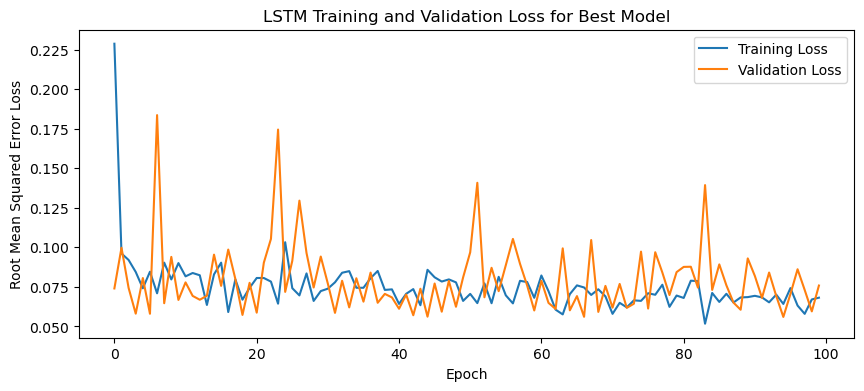

1/1 - 1s - loss: 0.0760 - 1s/epoch - 1s/step
Test Loss: 0.07597759366035461
Fold 2:
Epoch 1/100
19/19 [==============================] - 5s 93ms/step - loss: 0.2205 - val_loss: 0.0340
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0753 - val_loss: 0.0754
Epoch 3/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0855 - val_loss: 0.0406
Epoch 4/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0825 - val_loss: 0.0549
Epoch 5/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0638 - val_loss: 0.0433
Epoch 6/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0715 - val_loss: 0.0464
Epoch 7/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0695 - val_loss: 0.0569
Epoch 8/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0691 - val_loss: 0.0433
Epoch 9/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0738 - val_loss: 0.0925
Epoch 10/100
19/

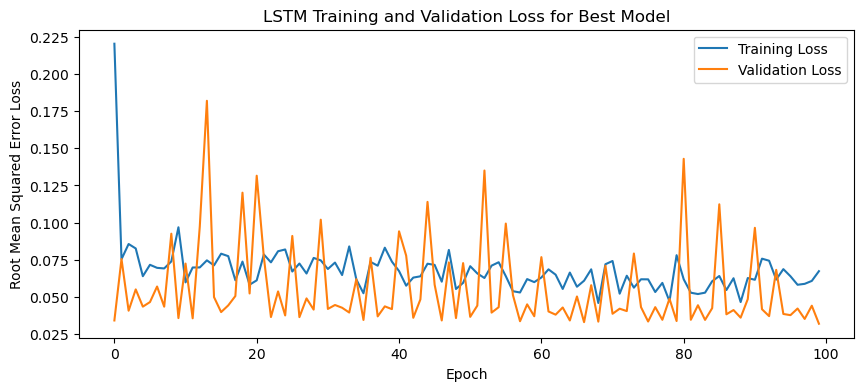

1/1 - 1s - loss: 0.1447 - 1s/epoch - 1s/step
Test Loss: 0.1447310745716095
Fold 3:
Epoch 1/100
19/19 [==============================] - 5s 97ms/step - loss: 0.2230 - val_loss: 0.0679
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0802 - val_loss: 0.1522
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0956 - val_loss: 0.0437
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0836 - val_loss: 0.1242
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0775 - val_loss: 0.0503
Epoch 6/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0903 - val_loss: 0.1033
Epoch 7/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0825 - val_loss: 0.1645
Epoch 8/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0916 - val_loss: 0.0830
Epoch 9/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0931 - val_loss: 0.0563
Epoch 10/100
19/1

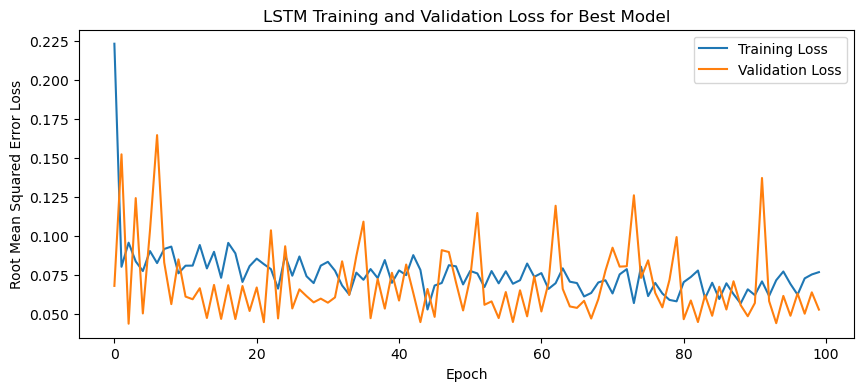

1/1 - 1s - loss: 0.0260 - 1s/epoch - 1s/step
Test Loss: 0.025987012311816216
Fold 4:
Epoch 1/100
20/20 [==============================] - 5s 77ms/step - loss: 0.2499 - val_loss: 0.0122
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0909 - val_loss: 0.1726
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0852 - val_loss: 0.1746
Epoch 4/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0881 - val_loss: 0.1780
Epoch 5/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0894 - val_loss: 0.0124
Epoch 6/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0961 - val_loss: 0.0307
Epoch 7/100
20/20 [==============================] - 1s 29ms/step - loss: 0.0844 - val_loss: 0.0367
Epoch 8/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0900 - val_loss: 0.0468
Epoch 9/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0777 - val_loss: 0.0593
Epoch 10/100
20

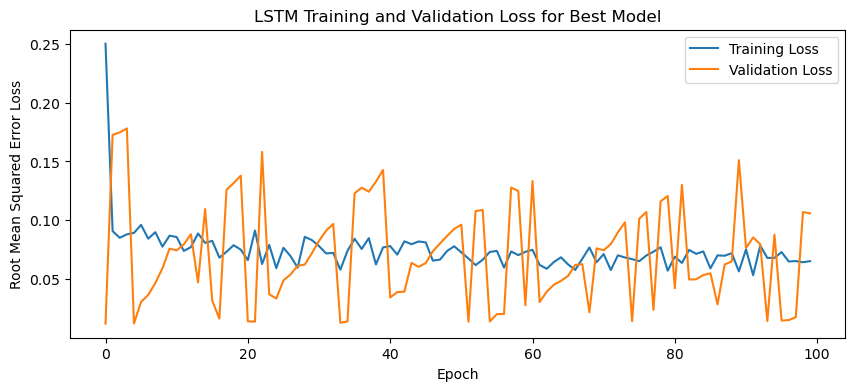

1/1 - 1s - loss: 0.0533 - 950ms/epoch - 950ms/step
Test Loss: 0.05327014997601509
Fold 5:
Epoch 1/100
19/19 [==============================] - 5s 80ms/step - loss: 0.2572 - val_loss: 0.1462
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0932 - val_loss: 0.0835
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0808 - val_loss: 0.1330
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0694 - val_loss: 0.0509
Epoch 5/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0575 - val_loss: 0.1684
Epoch 6/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0854 - val_loss: 0.0422
Epoch 7/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0762 - val_loss: 0.0396
Epoch 8/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0769 - val_loss: 0.1012
Epoch 9/100
19/19 [==============================] - 1s 30ms/step - loss: 0.0796 - val_loss: 0.0429
Epoch 10/1

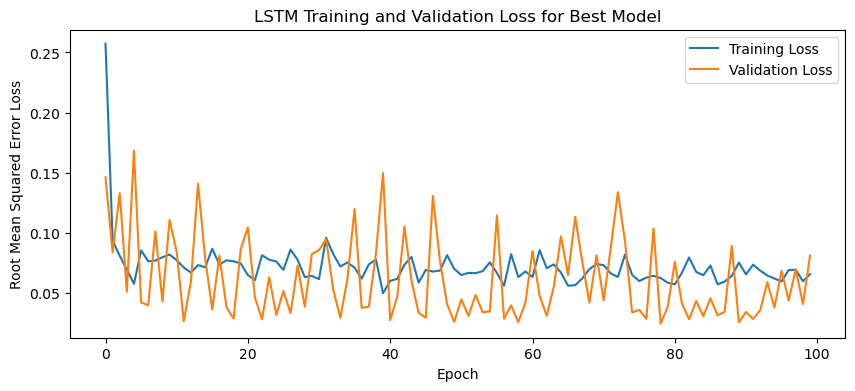

1/1 - 1s - loss: 0.0590 - 1s/epoch - 1s/step
Test Loss: 0.0590197890996933


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

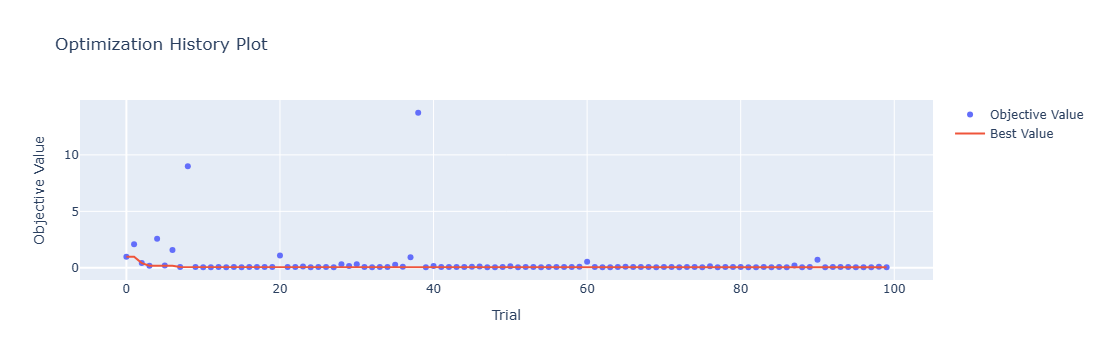

In [4]:
optuna.visualization.plot_optimization_history(study)

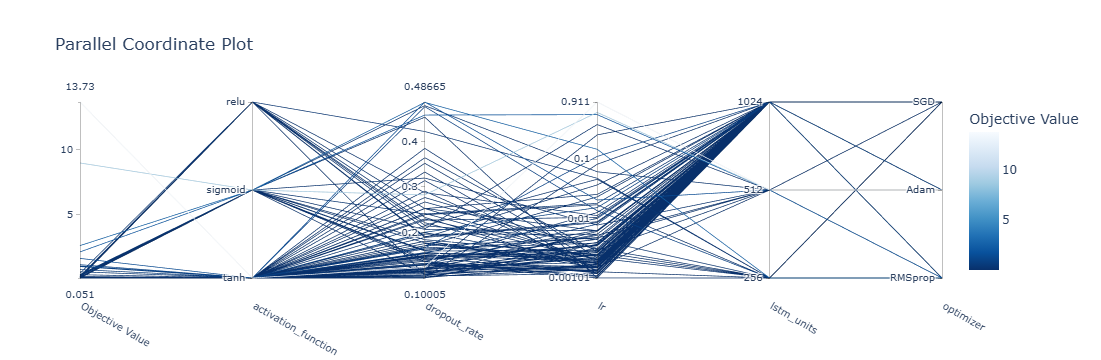

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

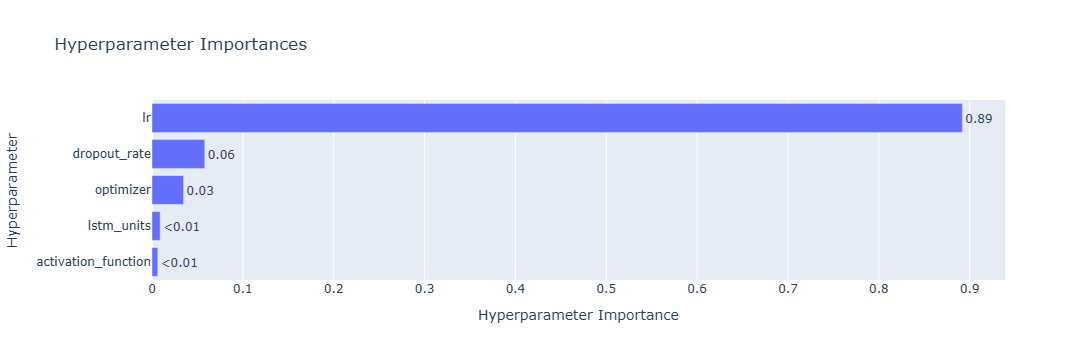

In [6]:
optuna.visualization.plot_param_importances(study)

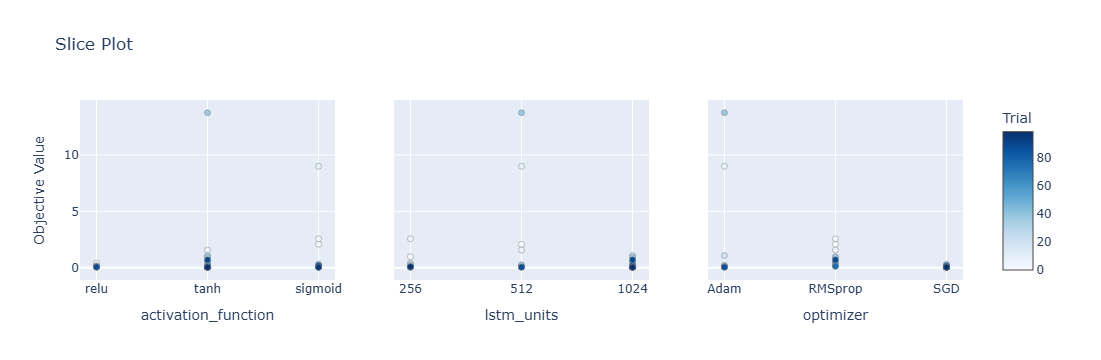

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

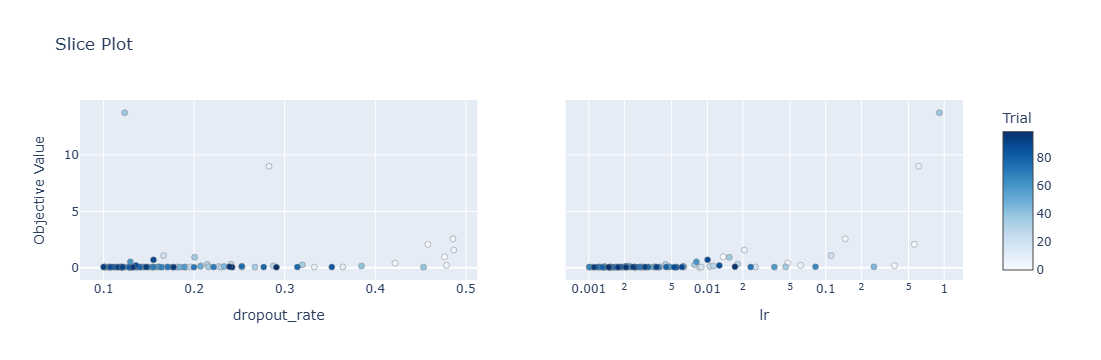

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 14s 192ms/step - loss: 0.2151 - accuracy: 0.0000e+00 - mae: 0.2151 - rmse: 0.2151 - mape: 36.5799 - pearson: nan - val_loss: 0.0638 - val_accuracy: 0.0000e+00 - val_mae: 0.0638 - val_rmse: 0.0638 - val_mape: 12.0704 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0849 - accuracy: 0.0000e+00 - mae: 0.0849 - rmse: 0.0849 - mape: 15.3666 - pearson: nan - val_loss: 0.0928 - val_accuracy: 0.0000e+00 - val_mae: 0.0928 - val_rmse: 0.0928 - val_mape: 17.8826 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 33ms/step - loss: 0.0894 - accu

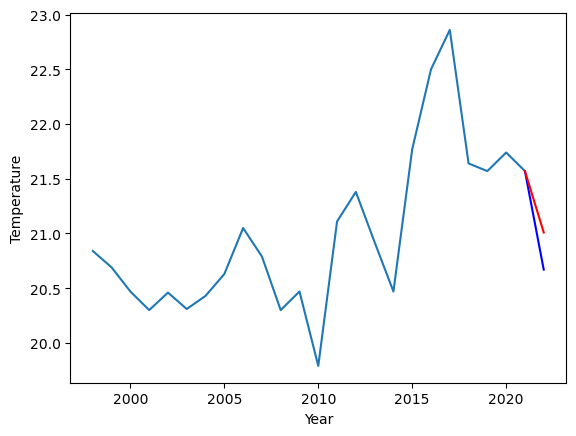

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.06		16.73		0.67


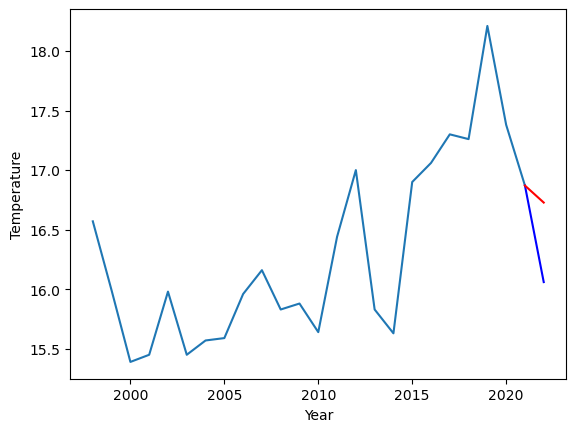

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.67  21.009511
1                1   16.06  16.727454


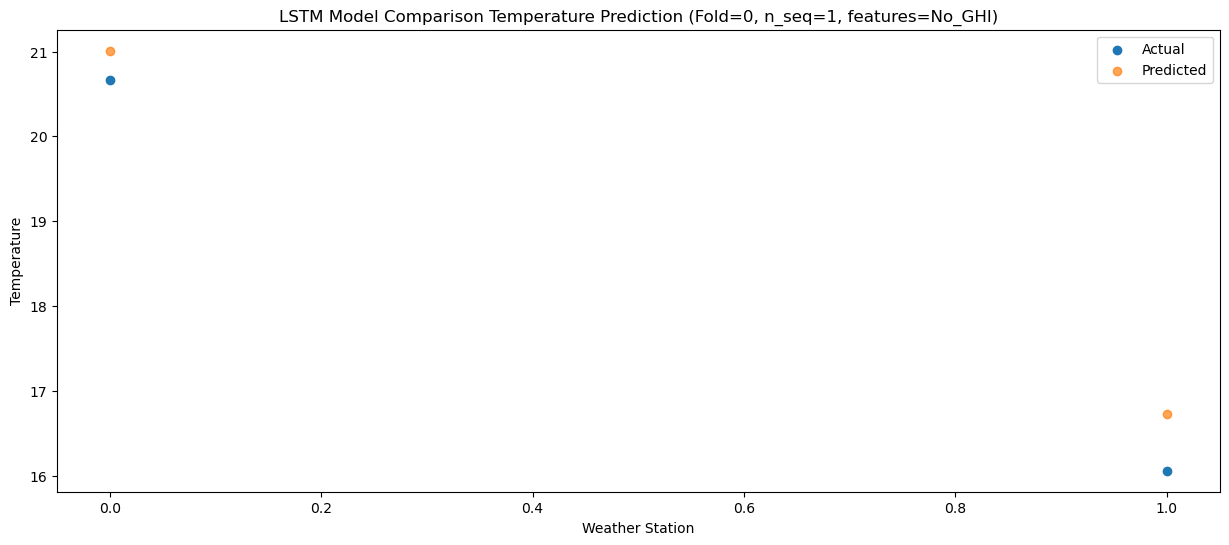

f, t:
[[20.67 16.06]]
[[21.00951098 16.72745425]]
Year at t+1:
t+1 SKRMSE: 0.529511
t+1 KRMSE: 0.529511
t+1 MAE: 0.503483
t+1 SKMAPE: 0.028993
t+1 R2_SCORE: 0.947228
t+1 KMAPE: 0.028993
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.529511
KRMSE: 0.529511
MAE: 0.503483
SKMAPE: 0.028993
R2_SCORE: 0.947228
KMAPE: 0.028993
PEARSON: 1.000000
Model: "sequential_515"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1030 (LSTM)            (1, 1, 1024)              5189632   
                                                                 
 dropout_1030 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1031 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1031 (Dropout)      (1, 1024)                 0         
                                  

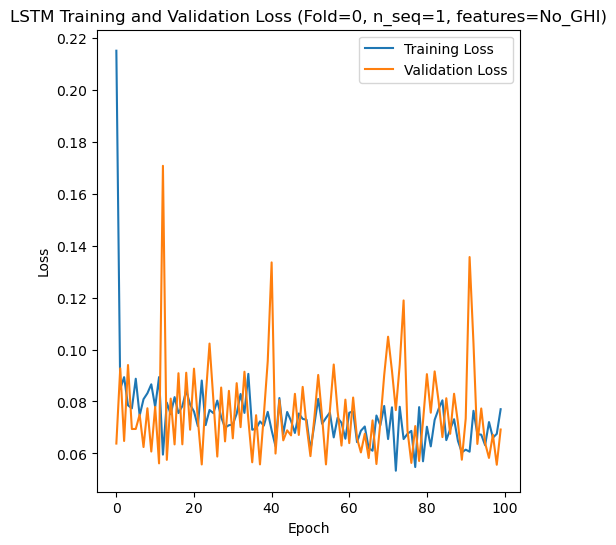

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 12s 193ms/step - loss: 0.2761 - accuracy: 0.0000e+00 - mae: 0.2761 - rmse: 0.2761 - mape: 43.1303 - pearson: nan - val_loss: 0.1570 - val_accuracy: 0.0000e+00 - val_mae: 0.1570 - val_rmse: 0.1570 - val_mape: 23.2388 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0812 - accuracy: 0.0000e+00 - mae: 0.0812 - rmse: 0.0812 - mape: 12.8186 - pearson: nan - val_loss: 0.0524 - val_accuracy: 0.0000e+00 - val_mae: 0.0524 - val_rmse: 0.0524 - val_mape: 8.2532 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0686 - accura

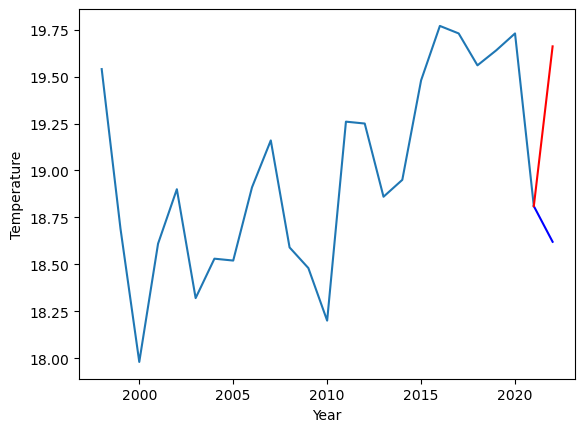

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.30		19.79		0.49


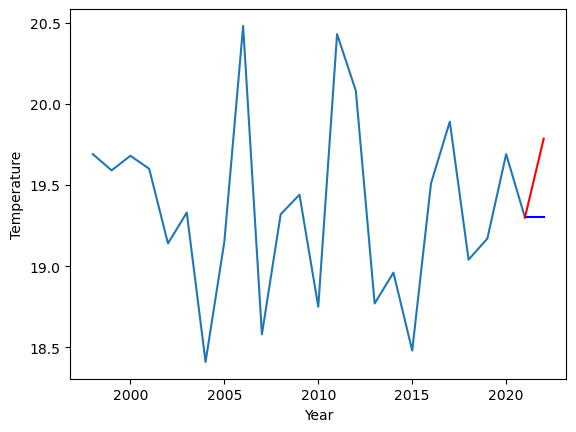

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   18.62  19.661142
1                1   19.30  19.786027


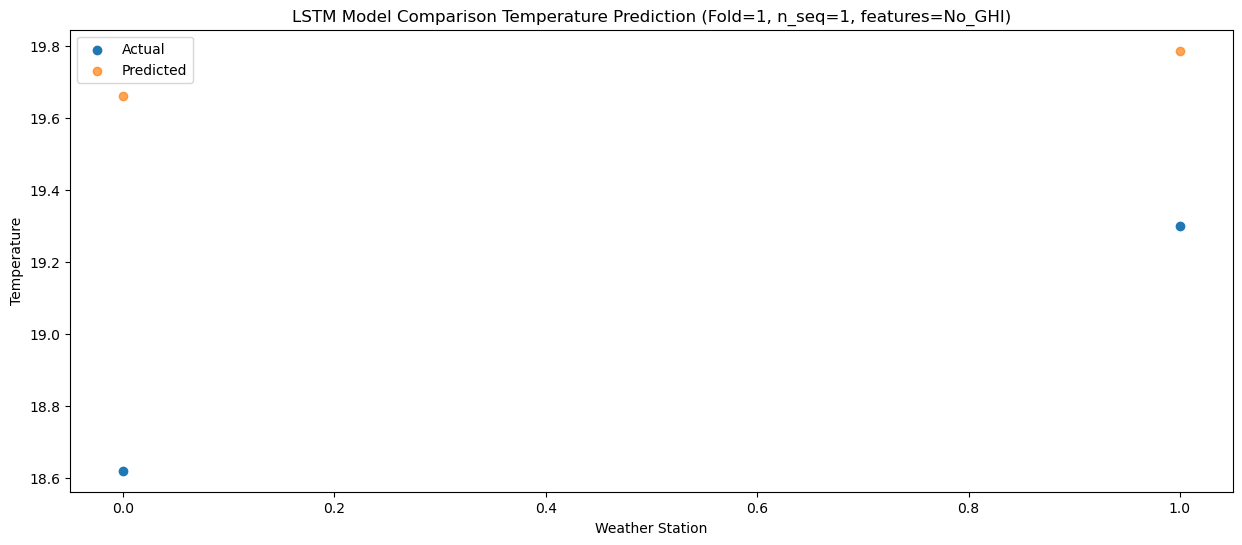

f, t:
[[18.62 19.3 ]]
[[19.66114186 19.78602653]]
Year at t+1:
t+1 SKRMSE: 0.812465
t+1 KRMSE: 0.812465
t+1 MAE: 0.763584
t+1 SKMAPE: 0.040549
t+1 R2_SCORE: -4.710200
t+1 KMAPE: 0.040549
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.812465
KRMSE: 0.812465
MAE: 0.763584
SKMAPE: 0.040549
R2_SCORE: -4.710200
KMAPE: 0.040549
PEARSON: 1.000000
Model: "sequential_516"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1032 (LSTM)            (1, 1, 1024)              5189632   
                                                                 
 dropout_1032 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1033 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1033 (Dropout)      (1, 1024)                 0         
                                

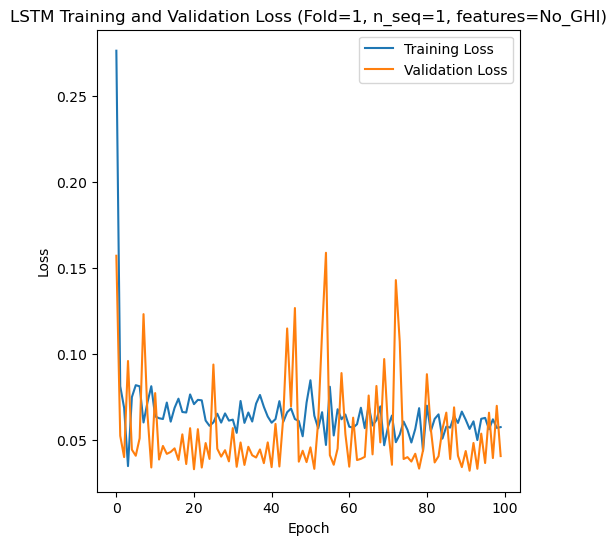

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 7s 95ms/step - loss: 0.2328 - accuracy: 0.0000e+00 - mae: 0.2328 - rmse: 0.2328 - mape: 38.5360 - pearson: nan - val_loss: 0.0623 - val_accuracy: 0.0000e+00 - val_mae: 0.0623 - val_rmse: 0.0623 - val_mape: 10.4913 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0844 - accuracy: 0.0000e+00 - mae: 0.0844 - rmse: 0.0844 - mape: 13.6495 - pearson: nan - val_loss: 0.1028 - val_accuracy: 0.0000e+00 - val_mae: 0.1028 - val_rmse: 0.1028 - val_mape: 15.9376 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0792 - accurac

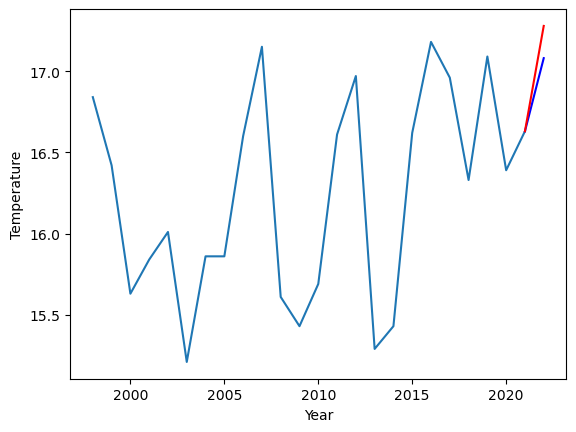

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.50		13.99		0.49


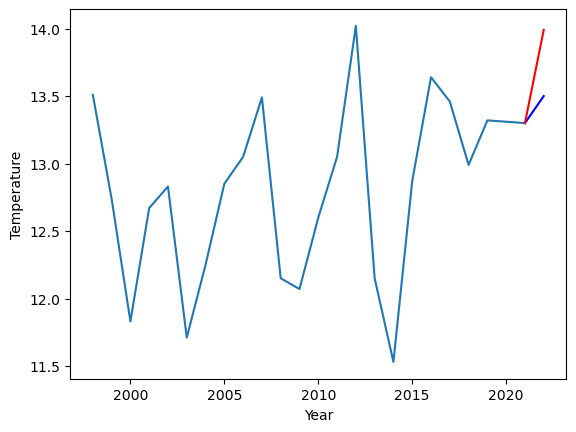

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.08  17.278393
1                1   13.50  13.990447


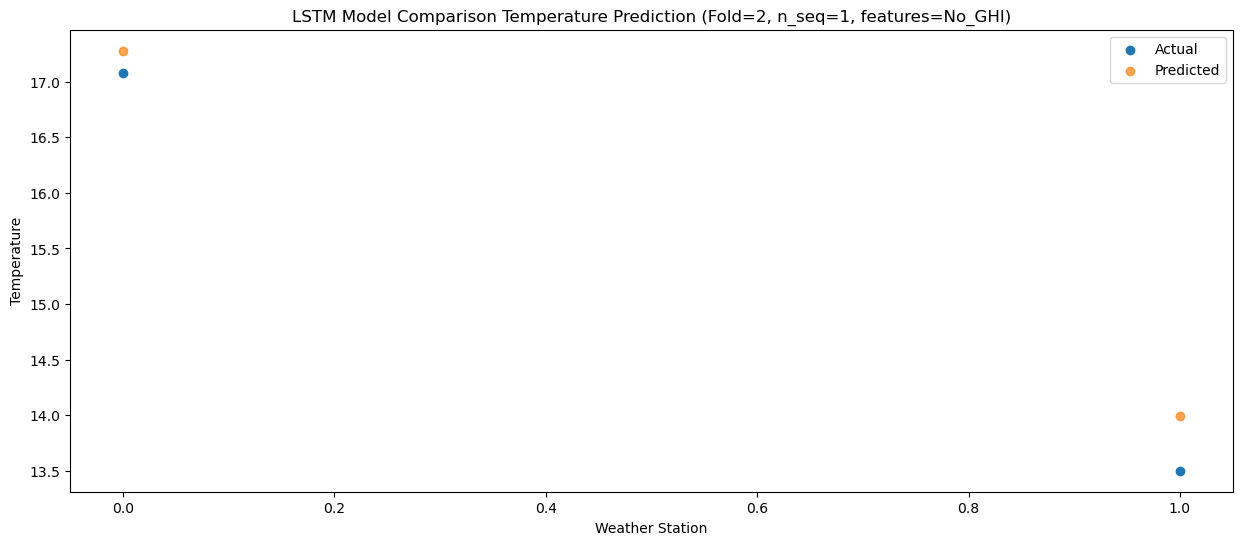

f, t:
[[17.08 13.5 ]]
[[17.27839347 13.99044747]]
Year at t+1:
t+1 SKRMSE: 0.374098
t+1 KRMSE: 0.374098
t+1 MAE: 0.344420
t+1 SKMAPE: 0.023972
t+1 R2_SCORE: 0.956322
t+1 KMAPE: 0.023972
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.374098
KRMSE: 0.374098
MAE: 0.344420
SKMAPE: 0.023972
R2_SCORE: 0.956322
KMAPE: 0.023972
PEARSON: 1.000000
Model: "sequential_517"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1034 (LSTM)            (1, 1, 1024)              5189632   
                                                                 
 dropout_1034 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1035 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1035 (Dropout)      (1, 1024)                 0         
                                  

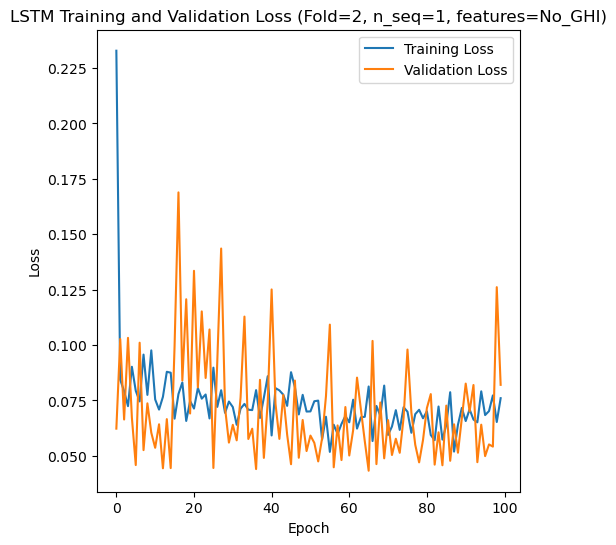

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 34s 484ms/step - loss: 0.2466 - accuracy: 0.0000e+00 - mae: 0.2466 - rmse: 0.2466 - mape: 38.5569 - pearson: nan - val_loss: 0.1149 - val_accuracy: 0.0000e+00 - val_mae: 0.1149 - val_rmse: 0.1149 - val_mape: 15.9713 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 2s 107ms/step - loss: 0.0791 - accuracy: 0.0000e+00 - mae: 0.0791 - rmse: 0.0791 - mape: 12.4118 - pearson: nan - val_loss: 0.0775 - val_accuracy: 0.0000e+00 - val_mae: 0.0775 - val_rmse: 0.0775 - val_mape: 10.8592 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 2s 92ms/step - loss: 0.1017 - accur

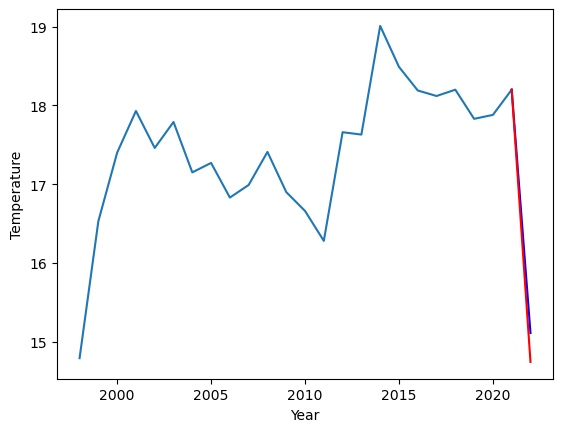

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.86		14.04		0.18


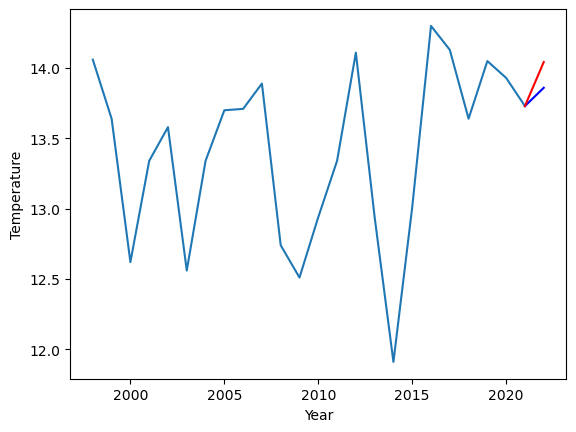

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   15.11  14.742587
1                1   13.86  14.043082


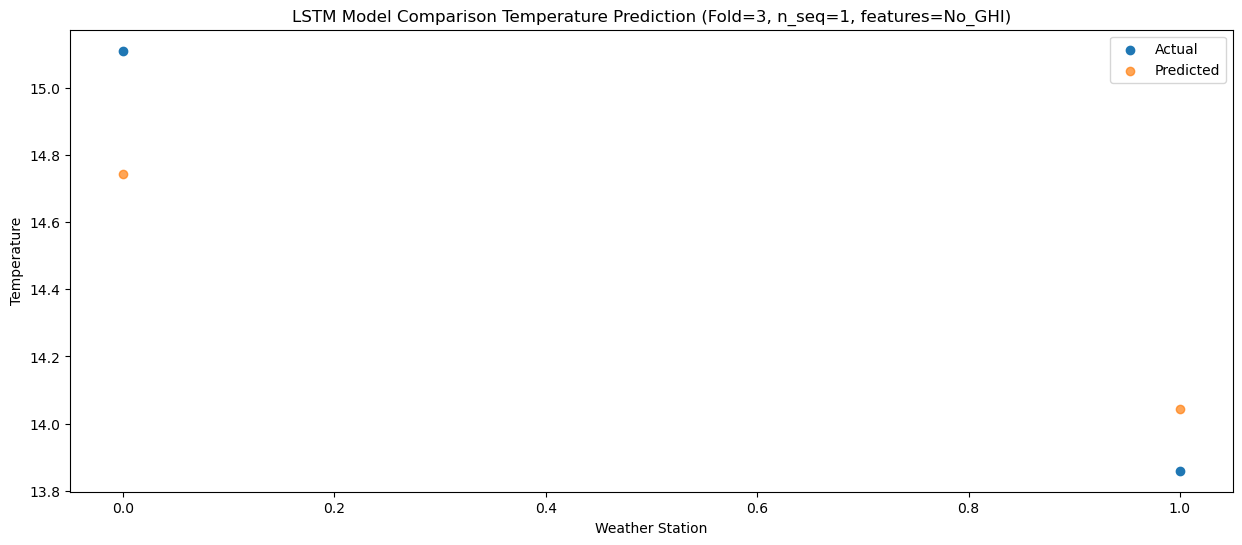

f, t:
[[15.11 13.86]]
[[14.74258695 14.04308219]]
Year at t+1:
t+1 SKRMSE: 0.290268
t+1 KRMSE: 0.290268
t+1 MAE: 0.275248
t+1 SKMAPE: 0.018763
t+1 R2_SCORE: 0.784305
t+1 KMAPE: 0.018763
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.290268
KRMSE: 0.290268
MAE: 0.275248
SKMAPE: 0.018763
R2_SCORE: 0.784305
KMAPE: 0.018763
PEARSON: 1.000000
Model: "sequential_518"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1036 (LSTM)            (1, 1, 1024)              5189632   
                                                                 
 dropout_1036 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1037 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1037 (Dropout)      (1, 1024)                 0         
                                  

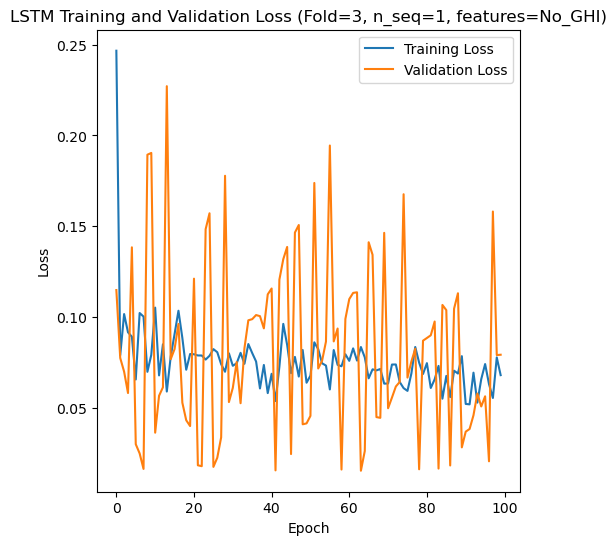

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 26s 408ms/step - loss: 0.2186 - accuracy: 0.0000e+00 - mae: 0.2186 - rmse: 0.2186 - mape: 35.9944 - pearson: nan - val_loss: 0.1064 - val_accuracy: 0.0000e+00 - val_mae: 0.1064 - val_rmse: 0.1064 - val_mape: 16.4095 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 105ms/step - loss: 0.0723 - accuracy: 0.0000e+00 - mae: 0.0723 - rmse: 0.0723 - mape: 12.3813 - pearson: nan - val_loss: 0.1281 - val_accuracy: 0.0000e+00 - val_mae: 0.1281 - val_rmse: 0.1281 - val_mape: 19.2311 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0884 - acc

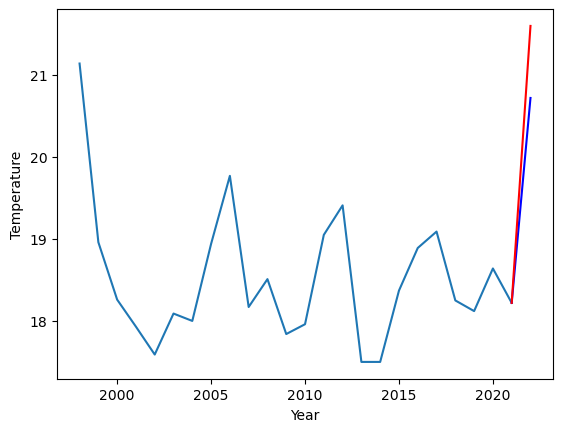

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.25		13.41		0.16


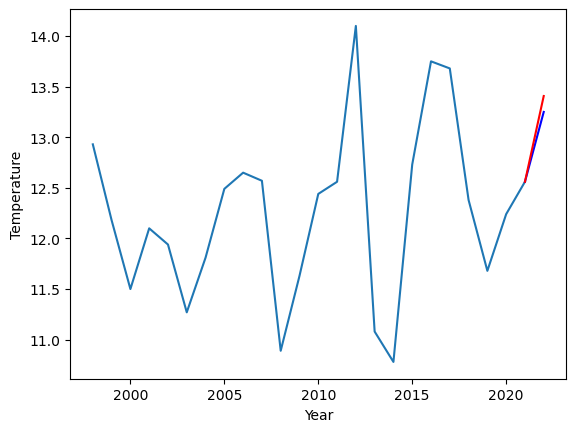

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.72  21.598789
1                1   13.25  13.407400


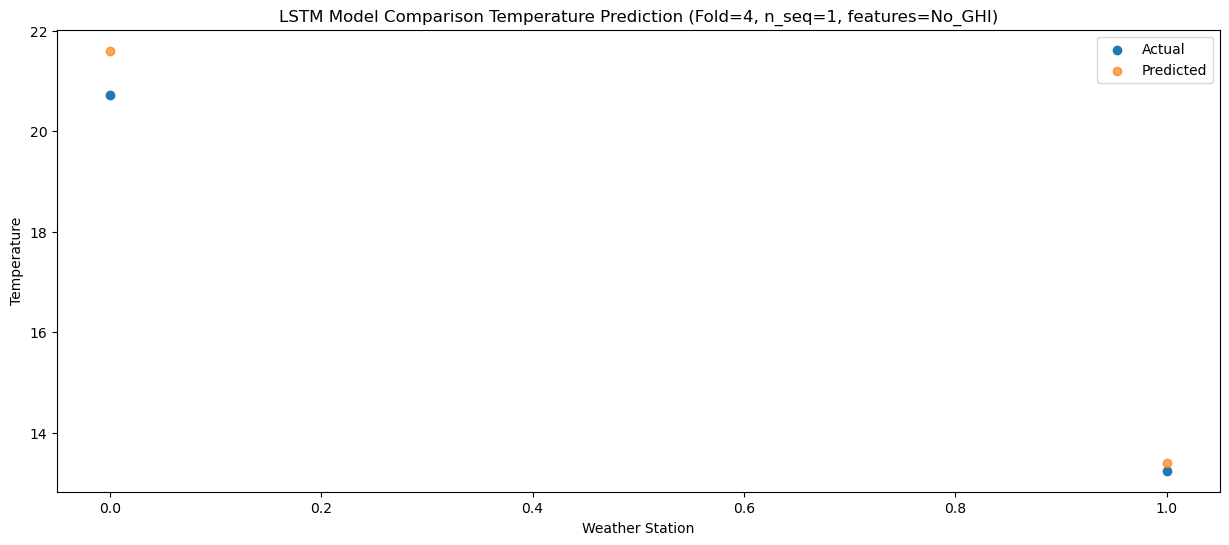

f, t:
[[20.72 13.25]]
[[21.59878896 13.4073998 ]]
Year at t+1:
t+1 SKRMSE: 0.631286
t+1 KRMSE: 0.631286
t+1 MAE: 0.518094
t+1 SKMAPE: 0.027146
t+1 R2_SCORE: 0.971433
t+1 KMAPE: 0.027146
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.631286
KRMSE: 0.631286
MAE: 0.518094
SKMAPE: 0.027146
R2_SCORE: 0.971433
KMAPE: 0.027146
PEARSON: 1.000000
Model: "sequential_519"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1038 (LSTM)            (1, 1, 1024)              5189632   
                                                                 
 dropout_1038 (Dropout)      (1, 1, 1024)              0         
                                                                 
 lstm_1039 (LSTM)            (1, 1024)                 8392704   
                                                                 
 dropout_1039 (Dropout)      (1, 1024)                 0         
                                  

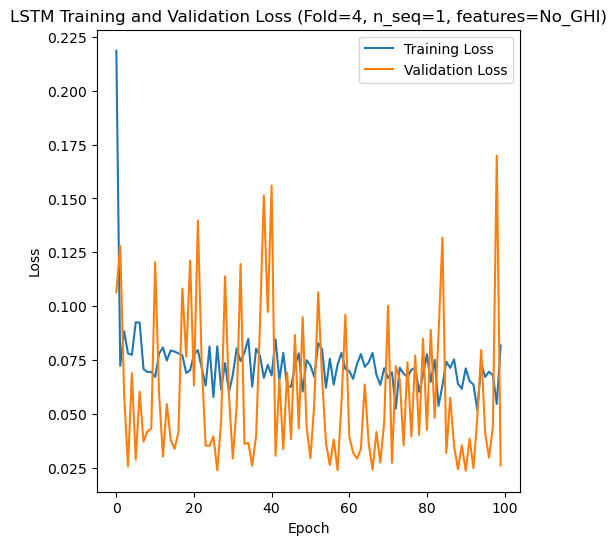

[[0.5295105670847134], [0.8124648175337903], [0.3740980435169825], [0.290268354935861], [0.6312862798036629]]
[[array(0.52951057)], [array(0.81246482)], [array(0.37409804)], [array(0.29026835)], [array(0.63128628)]]
[[0.5034826138615589], [0.7635841953754436], [0.3444204723834998], [0.27524761877953985], [0.5180943787097938]]
[[0.02899267089861026], [0.04054898334774684], [0.023972492629547648], [0.018762639943597417], [0.02714591227831687]]
[[0.9472275322148165], [-4.7101996516454046], [0.9563217920279534], [0.7843053622344417], [0.9714325491475335]]
[[array(0.02899267)], [array(0.04054898)], [array(0.02397249)], [array(0.01876264)], [array(0.02714591)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[20.67 16.06 18.62 19.3  17.08 13.5  15.11 13.86 20.72 13.25]
[21.00951098 16.72745425 19.66114186 19.78602653 17.27839347 13.99044747
 14.74258695 14.04308219 21.59878896 13.4073998 ]
Accuracy Results:
RMSE for each fold:
[[0.5295105670847134], [0.8124648175337903], [0

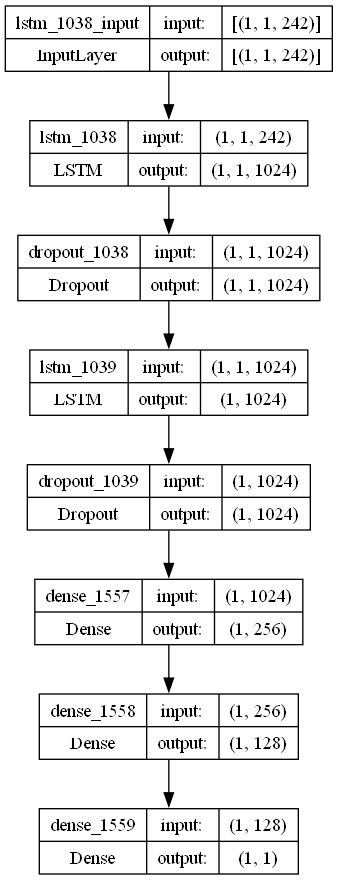

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.005489935837225713
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.12003441161825378

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)